In [2]:
import argparse
import gc
import hashlib
import itertools
import logging
import math
import os
import threading
import warnings
from pathlib import Path
from typing import Optional
import psutil
import json

import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import datasets
import diffusers
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, UNet2DConditionModel
from diffusers import DDPMScheduler, PNDMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version
from diffusers.utils.import_utils import is_xformers_available
from huggingface_hub import HfFolder, Repository, whoami
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig, CLIPFeatureExtractor
from peft import PeftModel, LoraConfig, get_peft_model_state_dict, set_peft_model_state_dict

# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
check_min_version("0.10.0.dev0")

logger = get_logger(__name__)


MODEL_NAME = "CompVis/stable-diffusion-v1-4"  # "stabilityai/stable-diffusion-2-1-base"
INSTANCE_PROMPT = "a photo of sks dog"
base_path = "/home/sourab/temp/"


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues


In [3]:
def get_lora_sd_pipeline(
    ckpt_dir, base_model_name_or_path=None, dtype=torch.float16, device="cuda", adapter_name="default"
):
    unet_sub_dir = os.path.join(ckpt_dir, "unet")
    text_encoder_sub_dir = os.path.join(ckpt_dir, "text_encoder")
    if os.path.exists(text_encoder_sub_dir) and base_model_name_or_path is None:
        config = LoraConfig.from_pretrained(text_encoder_sub_dir)
        base_model_name_or_path = config.base_model_name_or_path

    if base_model_name_or_path is None:
        raise ValueError("Please specify the base model name or path")

    pipe = StableDiffusionPipeline.from_pretrained(
        base_model_name_or_path, torch_dtype=dtype, requires_safety_checker=False
    ).to(device)
    pipe.unet = PeftModel.from_pretrained(pipe.unet, unet_sub_dir, adapter_name=adapter_name)

    if os.path.exists(text_encoder_sub_dir):
        pipe.text_encoder = PeftModel.from_pretrained(
            pipe.text_encoder, text_encoder_sub_dir, adapter_name=adapter_name
        )

    if dtype in (torch.float16, torch.bfloat16):
        pipe.unet.half()
        pipe.text_encoder.half()

    pipe.to(device)
    return pipe


def load_adapter(pipe, ckpt_dir, adapter_name):
    unet_sub_dir = os.path.join(ckpt_dir, "unet")
    text_encoder_sub_dir = os.path.join(ckpt_dir, "text_encoder")
    pipe.unet.load_adapter(unet_sub_dir, adapter_name=adapter_name)
    if os.path.exists(text_encoder_sub_dir):
        pipe.text_encoder.load_adapter(text_encoder_sub_dir, adapter_name=adapter_name)


def set_adapter(pipe, adapter_name):
    pipe.unet.set_adapter(adapter_name)
    if isinstance(pipe.text_encoder, PeftModel):
        pipe.text_encoder.set_adapter(adapter_name)


def merging_lora_with_base(pipe, ckpt_dir, adapter_name="default"):
    unet_sub_dir = os.path.join(ckpt_dir, "unet")
    text_encoder_sub_dir = os.path.join(ckpt_dir, "text_encoder")
    if isinstance(pipe.unet, PeftModel):
        pipe.unet.set_adapter(adapter_name)
    else:
        pipe.unet = PeftModel.from_pretrained(pipe.unet, unet_sub_dir, adapter_name=adapter_name)
    pipe.unet = pipe.unet.merge_and_unload()

    if os.path.exists(text_encoder_sub_dir):
        if isinstance(pipe.text_encoder, PeftModel):
            pipe.text_encoder.set_adapter(adapter_name)
        else:
            pipe.text_encoder = PeftModel.from_pretrained(
                pipe.text_encoder, text_encoder_sub_dir, adapter_name=adapter_name
            )
        pipe.text_encoder = pipe.text_encoder.merge_and_unload()

    return pipe


def create_weighted_lora_adapter(pipe, adapters, weights, adapter_name="default"):
    pipe.unet.add_weighted_adapter(adapters, weights, adapter_name)
    if isinstance(pipe.text_encoder, PeftModel):
        pipe.text_encoder.add_weighted_adapter(adapters, weights, adapter_name)

    return pipe

In [4]:
%%time
pipe = get_lora_sd_pipeline(os.path.join(base_path, "dog_dreambooth_updated"), adapter_name="dog")

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


CPU times: user 13.2 s, sys: 7.55 s, total: 20.8 s
Wall time: 5.89 s


In [5]:
%%time
load_adapter(pipe, os.path.join(base_path, "toy_dreambooth"), adapter_name="toy")

CPU times: user 90 ms, sys: 890 µs, total: 90.9 ms
Wall time: 90.2 ms


In [6]:
pipe = create_weighted_lora_adapter(pipe, ["toy", "dog"], [1.0, 1.05], adapter_name="toy_dog")

In [7]:
%%time
set_adapter(pipe, adapter_name="dog")

CPU times: user 5.74 ms, sys: 373 µs, total: 6.11 ms
Wall time: 6.04 ms


  0%|          | 0/50 [00:00<?, ?it/s]

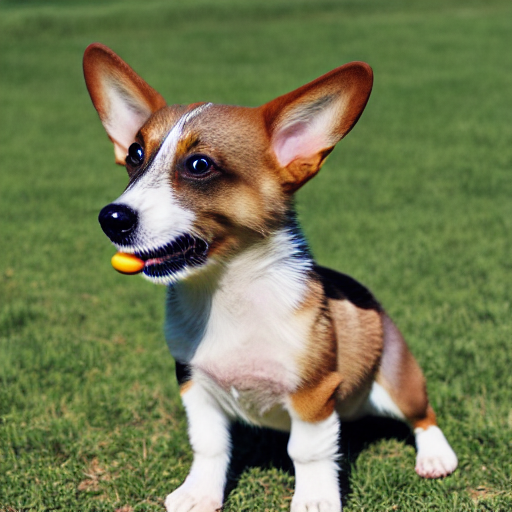

In [8]:
prompt = "sks dog playing fetch in the park"
negative_prompt = "low quality, blurry, unfinished"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7, negative_prompt=negative_prompt).images[0]
image

In [9]:
%%time
set_adapter(pipe, adapter_name="toy")

CPU times: user 7.74 ms, sys: 0 ns, total: 7.74 ms
Wall time: 7.31 ms


  0%|          | 0/50 [00:00<?, ?it/s]

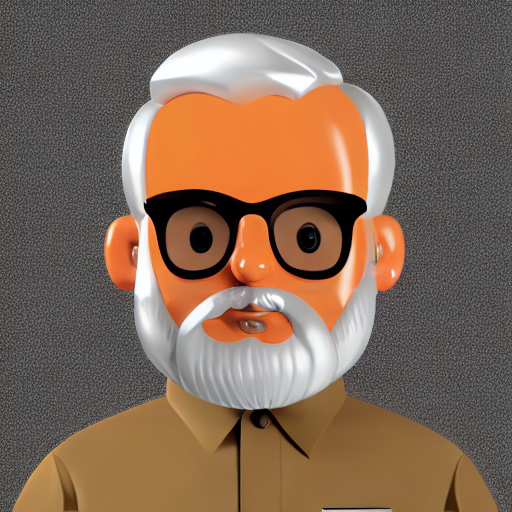

In [13]:
prompt = "narendra modi rendered in the style of <1>"
negative_prompt = "low quality, blurry, unfinished"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7, negative_prompt=negative_prompt).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

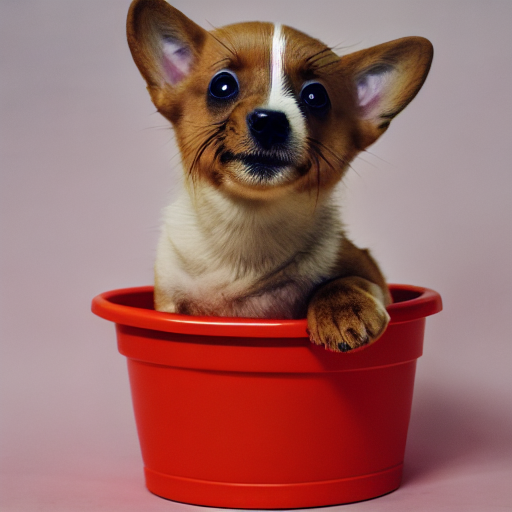

In [24]:
set_adapter(pipe, adapter_name="dog")
prompt = "sks dog in a big red bucket"
negative_prompt = "low quality, blurry, unfinished"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7, negative_prompt=negative_prompt).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

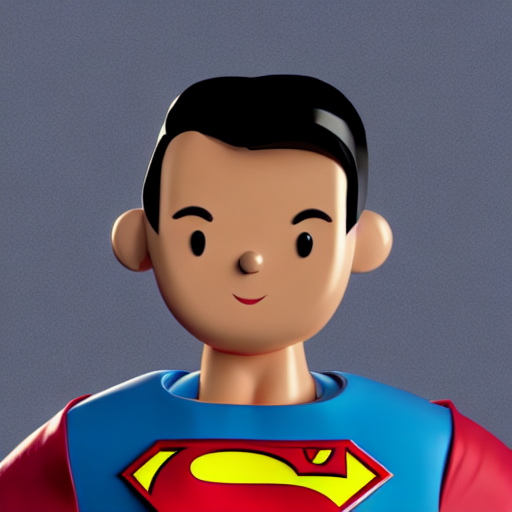

In [15]:
set_adapter(pipe, adapter_name="toy")
prompt = "superman rendered in the style of <1>, close up potrait"
negative_prompt = "low quality, blurry, unfinished"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7, negative_prompt=negative_prompt).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

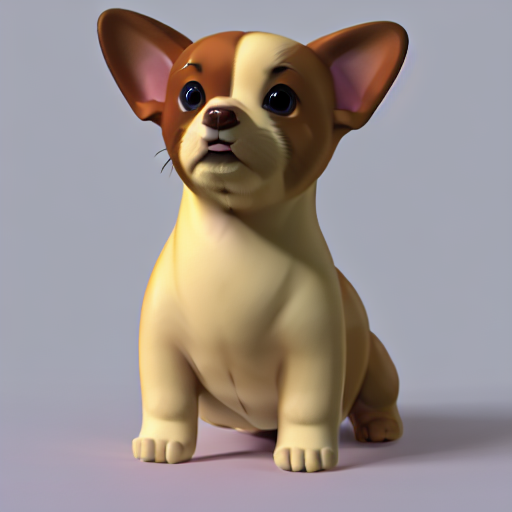

In [34]:
set_adapter(pipe, adapter_name="toy_dog")
prompt = "sks dog rendered in the style of <1>, close up potrait, 4K HD"
negative_prompt = "low quality, blurry, unfinished"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7, negative_prompt=negative_prompt).images[0]
image